In [34]:
import deepquantum as dq
import deepquantum.photonic as dqp
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [35]:
cir = dq.QumodeCircuit(nmode=2, init_state='vac', 
                       backend='gaussian', 
                       name='try', noise=False)
cir.s(1, [1])
state = cir()
print(state[0])
print(state[1])

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1353, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 7.3891]]])
tensor([[[0.],
         [0.],
         [0.],
         [0.]]])


In [36]:
cov = torch.eye(4)
mean = torch.zeros(4)
qstate = dq.GaussianState(nmode=2, state=[cov, mean])
qstate.cov = torch.eye(4) * 2
qstate.cov

tensor([[2., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 2.]])

In [37]:
qstate

GaussianState()

In [38]:
para = np.log(10)/10
loss = 2.5
np.exp(-para*loss)*torch.eye(4)

tensor([[0.5623, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5623, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5623, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5623]])

In [39]:
cir = dq.QumodeCircuit(nmode=2, init_state='vac', 
                       backend='gaussian', 
                       name='try', noise=False)

cir.s(r=1, theta=0, wires=[0])
cir.bs_ry([0, 1], inputs=[torch.pi])
cir.ps(1, [11])

state = cir.forward()
print(state[0])
print(state[1])

cir.loss(1, loss=1)

# print(cir.get_unitary())

#线路可视化
cir.draw('pic/CM_circ_num_ME.svg')

tensor([[[ 1.0000e+00,  1.6727e-10,  0.0000e+00, -3.7795e-08],
         [ 1.6727e-10,  7.3889e+00, -2.7927e-07,  3.2102e-02],
         [ 0.0000e+00, -2.7927e-07,  1.0000e+00, -1.2360e-09],
         [-3.7795e-08,  3.2102e-02, -1.2360e-09,  1.3548e-01]]])
tensor([[[0.],
         [0.],
         [0.],
         [0.]]])


In [40]:
state = cir.forward()
print(state[0])
print(state[1])

tensor([[[ 1.0000e+00,  1.6727e-10,  0.0000e+00, -3.7795e-08],
         [ 1.6727e-10,  7.3889e+00, -2.7927e-07,  3.2102e-02],
         [ 0.0000e+00, -2.7927e-07,  1.0000e+00, -1.2360e-09],
         [-3.7795e-08,  3.2102e-02, -1.2360e-09,  1.3548e-01]]],
       grad_fn=<UnsqueezeBackward0>)
tensor([[[0.],
         [0.],
         [0.],
         [0.]]], grad_fn=<UnsqueezeBackward0>)


In [41]:
Ns: int = 1
Nm: int = 2
NL: int = 0
eta: float = 0
delta_k: float = 0
r_k: float = 0
phi_k: float = [0,1]
shots: int = 10000
init_state: any = 'vac'
s_r: float = 0
s_phi: float = 0
m1_r: float = 0
m1_phi: float = 0

N_total = Ns + Nm + NL
theta = 2*eta - np.pi

cir = dq.QumodeCircuit(nmode=N_total, init_state=init_state, 
                    backend='gaussian', 
                    name='try', noise=False,
                    mu = 0, sigma = 0)

# s0,m1, two-mode squeezed vacuum (TMSV) state 
# # S(r,theta)
cir.s2(wires=[0, 1], r=2, theta=0)
cir.loss(0, loss=0.5)
cir.loss(1, loss=0.5)

# m2, single-mode squeezing vacuum (SMSV) state
# for i in range(Nm+NL-1):
#     cir.s(wires=2+i, r=r_k, theta=phi_k)

for i in range(Nm+NL-1):
    cir.s(wires=2+i, r=r_k, theta=phi_k[i % 2])
    cir.loss(2+i, loss=0.5)

cir.loss(0, loss=0.5)
cir.loss(0, loss=0.5)

for i in range(N_total-2):
    for j in range(N_total-i-2):
        cir.bs_ry(wires=[j+1,j+2], inputs=theta)
        cir.loss(j+1, loss=0.5)
        cir.loss(j+2, loss=0.5)
        cir.ps(j+1, [delta_k])
        cir.loss(j+1, loss=0.5)
        cir.loss(j+2, loss=0.5)

#线路可视化
cir.draw('pic/CM_circ_num_ME{}.svg'.format(N_total))

In [42]:
state = cir.forward()

# 这里measure_homodyne测量对应的物理量是正交算符 $$\hat x$$ 和 $$\hat p$$ 的值，
# photon_number_mean_var对应的是每个mode的光子数的平均值和方差。
# Use ``xxpp`` convention
# 第一个光子：x1，x2，... p1，p2...
# 第二个光子：x1，x2，... p1，p2...

sample = cir.measure_homodyne(shots=shots)

# ( [平均值], [方差] )
photon_number = cir.photon_number_mean_var()
print('number of modes: ', N_total)
print('sample: ', sample)
print('sample[0]: ', sample[0])
print('size of sample: ', sample.size())
print('\n全部qubit的每光子数的平均值和方差: ', photon_number)

number of modes:  3
sample:  tensor([[ 0.7958, -0.0645, -0.6587,  0.4543, -0.1707,  0.2891],
        [ 0.9678, -1.9907, -1.0894, -9.4154,  0.7987, -9.3052],
        [ 3.8839,  0.4301, -3.7641, -0.5660, -0.8602, -0.6002],
        ...,
        [-6.1166, -0.6606,  6.3576, -3.6339, -0.1256, -3.3348],
        [-1.5552,  1.8793,  1.8381, -3.1764, -1.9230, -3.5826],
        [ 2.7373, -2.5239, -2.5156, 11.8857,  0.3423, 11.9908]])
sample[0]:  tensor([ 0.7958, -0.0645, -0.6587,  0.4543, -0.1707,  0.2891])
size of sample:  torch.Size([10000, 6])

全部qubit的每光子数的平均值和方差:  (tensor([13.1541,  0.0000, 13.1541], grad_fn=<SqueezeBackward0>), tensor([186.1849,   0.0000, 186.1849], grad_fn=<SqueezeBackward0>))


In [43]:
s_x = np.array(sample.T[:Ns]) 
s_p = np.array(sample.T[Ns+Nm+NL:2*Ns+Nm+NL][:])
m_x = np.array(sample.T[Ns:(Ns+Nm)][:]) 
m_p = np.array(sample.T[2*Ns+Nm+NL:2*Ns+2*Nm+NL][:])
e_x = np.array(sample.T[Ns+Nm:Ns+Nm+NL][:])
e_p = np.array(sample.T[2*Ns+2*Nm+NL:][:])

print('s_x: ', s_x)
print('s_p: ', s_p)
print('m_x: ', m_x)
print('m_p: ', m_p)
print('e_x: ', e_x)
print('e_p: ', e_p)
# print('e_p: ', e_p)
# tensor([-1.7606, -1.8317,  0.1675,  0.0505,  0.4172,  0.1999, -0.9365, 0.7595, -0.5110, 
#         -0.1866,  0.0076,  2.5539,  0.6549,  0.2298, -0.5049, -2.2482, 0.2991, -0.8218])        #    s_xj   m1x      m2x     e1x       s_xk   m1p      m2p      e1p  

s_x:  [[ 0.79578364  0.9678299   3.883871   ... -6.1166434  -1.555159
   2.7372963 ]]
s_p:  [[ 0.45425105 -9.415446   -0.5659725  ... -3.6338928  -3.1764314
  11.885657  ]]
m_x:  [[-0.06447165 -1.9907267   0.4300564  ... -0.6605587   1.8792616
  -2.5238838 ]
 [-0.6587013  -1.0894179  -3.7641394  ...  6.357622    1.8381339
  -2.515577  ]]
m_p:  [[-0.17071418  0.798658   -0.8601582  ... -0.12558368 -1.9230088
   0.3423033 ]
 [ 0.28910005 -9.305237   -0.60018456 ... -3.3347647  -3.5826435
  11.99079   ]]
e_x:  []
e_p:  []


(-20.650860500335693,
 20.76007719039917,
 -26.230282402038576,
 21.829479789733888)

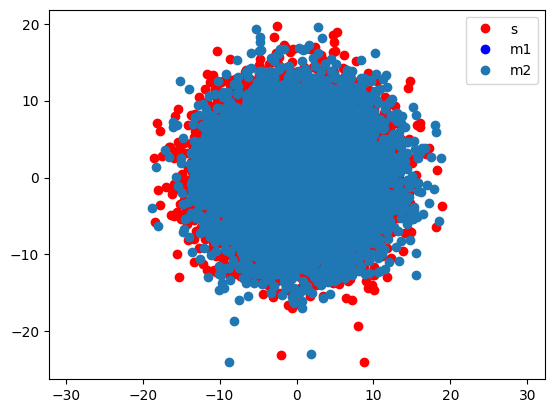

In [44]:
import matplotlib.pyplot as plt
plt.plot(s_x[0], s_p[0], 'ro', label='s')
plt.plot(m_x[0], m_p[0], 'bo', label='m1')
plt.plot(m_x[1], m_p[1], 'o', label='m2')
# plt.plot(e_x[0], e_p[0], 'go', label='e1')
# plt.plot(e_x[1], e_p[1], 'o', label='e2')
plt.legend()
plt.axis('equal')

(-26.148773860931396,
 21.825598430633544,
 -4.585592639446259,
 4.2978583693504335)

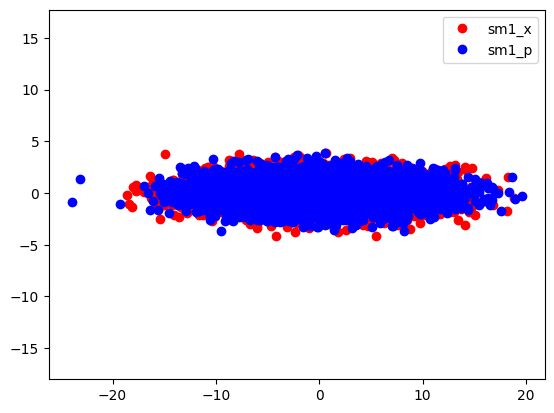

In [45]:
import matplotlib.pyplot as plt
plt.plot(s_x[0], m_x[0], 'ro', label='sm1_x')
plt.plot(s_p[0], m_p[0], 'bo', label='sm1_p')

plt.legend()
plt.axis('equal')

In [46]:
def get_sigma(xj, xk):
    return np.cov(xj, xk)

In [47]:
get_sigma(s_x, s_p)

array([[27.28648053,  0.08013126],
       [ 0.08013126, 27.56865902]])

In [48]:
sigma_s = np.zeros((2,2))
np.size(sigma_s)

4

In [49]:
sigma_s = np.zeros((2,2))
sigma_m1 = np.zeros((2,2))
sigma_m2 = np.zeros((2,2))

sigma_s = get_sigma(s_x, s_p)
sigma_m1 = get_sigma(m_x[0], m_p[0])
sigma_m2 = get_sigma(m_x[1], m_p[1])

sigma_s, sigma_m1, sigma_m2

(array([[27.28648053,  0.08013126],
        [ 0.08013126, 27.56865902]]),
 array([[1.04309802, 0.0101375 ],
        [0.0101375 , 1.0003399 ]]),
 array([[27.26441412, -0.07293413],
        [-0.07293413, 27.56143366]]))

$$\boldsymbol{\sigma} = \begin{bmatrix}
\sigma_{xx,aa} & \sigma_{xp,aa} & \sigma_{xx,ab} & \sigma_{xp,ab} \\
\sigma_{px,aa} & \sigma_{pp,aa} & \sigma_{px,ab} & \sigma_{pp,ab} \\
\sigma_{xx,ba} & \sigma_{xp,ba} & \sigma_{xx,bb} & \sigma_{xp,bb} \\
\sigma_{px,ba} & \sigma_{pp,ba} & \sigma_{px,bb} & \sigma_{pp,bb}
\end{bmatrix}$$

In [50]:
sigma_m12 = np.zeros((2*Nm,2*Nm))
sigma_sm1 = np.zeros((2*(Ns+1),2*(Ns+1)))
sigma_sm2 = np.zeros((2*(Ns+1),2*(Ns+1)))

choose = [['xxaa', 'xpaa', 'xxab', 'xpab'],
          ['pxaa', 'ppaa', 'pxab', 'ppab'],
          ['xxba', 'xpba', 'xxbb', 'xpbb'],
          ['pxba', 'ppba', 'pxbb', 'ppbb']]
index_m12 = {'xa':m_x[0], 'pa':m_p[0], 'xb':m_x[1], 'pb':m_p[1]}
index_sm1 = {'xa':s_x, 'pa':s_p, 'xb':m_x[0], 'pb':m_p[0]}
index_sm2 = {'xa':s_x, 'pa':s_p, 'xb':m_x[1], 'pb':m_p[1]}

for i in range(Nm*2):
    for j in range(Nm*2):
        sigma_m12[i][j] = get_sigma( index_m12[choose[i][j][0]+choose[i][j][2]], 
                               index_m12[choose[i][j][1]+choose[i][j][3]] )[0][1]
        sigma_sm1[i][j] = get_sigma( index_sm1[choose[i][j][0]+choose[i][j][2]], 
                               index_sm1[choose[i][j][1]+choose[i][j][3]] )[0][1]
        sigma_sm2[i][j] = get_sigma( index_sm2[choose[i][j][0]+choose[i][j][2]],
                                 index_sm2[choose[i][j][1]+choose[i][j][3]] )[0][1]

print('sigma_m12: \n', sigma_m12)
print('sigma_sm1: \n', sigma_sm1)
print('sigma_sm2: \n', sigma_sm2)


sigma_m12: 
 [[ 1.04309802e+00  1.01375027e-02  8.39348489e-02 -9.58179878e-02]
 [ 1.01375027e-02  1.00033990e+00  1.54179720e-02 -4.54942862e-02]
 [ 8.39348489e-02  1.54179720e-02  2.72644141e+01 -7.29341264e-02]
 [-9.58179878e-02 -4.54942862e-02 -7.29341264e-02  2.75614337e+01]]
sigma_sm1: 
 [[ 2.72864805e+01  8.01312581e-02 -8.59959109e-02 -1.33390090e-02]
 [ 8.01312581e-02  2.75686590e+01 -9.47605784e-02 -4.43403774e-02]
 [-8.59959109e-02 -9.47605784e-02  1.04309802e+00  1.01375027e-02]
 [-1.33390090e-02 -4.43403774e-02  1.01375027e-02  1.00033990e+00]]
sigma_sm2: 
 [[ 27.28648053   0.08013126 -27.25722582   0.07693952]
 [  0.08013126  27.56865902  -0.07563103  27.54658841]
 [-27.25722582  -0.07563103  27.26441412  -0.07293413]
 [  0.07693952  27.54658841  -0.07293413  27.56143366]]


$$
\boldsymbol{\sigma} = \begin{bmatrix}
\sigma_{xx,aa} & \sigma_{xp,aa} & \sigma_{xx,ab} & \sigma_{xp,ab} & \sigma_{xx,ac} & \sigma_{xp,ac} \\
\sigma_{px,aa} & \sigma_{pp,aa} & \sigma_{px,ab} & \sigma_{pp,ab} & \sigma_{px,ac} & \sigma_{pp,ac} \\
\sigma_{xx,ba} & \sigma_{xp,ba} & \sigma_{xx,bb} & \sigma_{xp,bb} & \sigma_{xx,bc} & \sigma_{xp,bc} \\
\sigma_{px,ba} & \sigma_{pp,ba} & \sigma_{px,bb} & \sigma_{pp,bb} & \sigma_{px,bc} & \sigma_{pp,bc} \\
\sigma_{xx,ca} & \sigma_{xp,ca} & \sigma_{xx,cb} & \sigma_{xp,cb} & \sigma_{xx,cc} & \sigma_{xp,cc} \\
\sigma_{px,ca} & \sigma_{pp,ca} & \sigma_{px,cb} & \sigma_{pp,cb} & \sigma_{px,cc} & \sigma_{pp,cc}
\end{bmatrix}
$$

In [51]:
sigma_sm12 = np.zeros((2*(Ns+Nm), 2*(Ns+Nm)))

choose = [['xxaa', 'xpaa', 'xxab', 'xpab', 'xxac', 'xpac'],
          ['pxaa', 'ppaa', 'pxab', 'ppab', 'pxac', 'ppac'],
          ['xxba', 'xpba', 'xxbb', 'xpbb', 'xxbc', 'xpbc'],
          ['pxba', 'ppba', 'pxbb', 'ppbb', 'pxbc', 'ppbc'],
          ['xxca', 'xpca', 'xxcb', 'xpcb', 'xxcc', 'xpcc'],
          ['pxca', 'ppca', 'pxcb', 'ppcb', 'pxcc', 'ppcc']]
index_sm12 = {'xa':s_x, 'pa':s_p, 'xb':m_x[0], 'pb':m_p[0], 'xc':m_x[1], 'pc':m_p[1]}

for i in range(2*(Ns+Nm)):
    for j in range(2*(Ns+Nm)):
        sigma_sm12[i][j] = get_sigma( index_sm12[choose[i][j][0]+choose[i][j][2]], 
                               index_sm12[choose[i][j][1]+choose[i][j][3]] )[0][1]

print('sigma_sm12: \n', sigma_sm12)

sigma_sm12: 
 [[ 2.72864805e+01  8.01312581e-02 -8.59959109e-02 -1.33390090e-02
  -2.72572258e+01  7.69395200e-02]
 [ 8.01312581e-02  2.75686590e+01 -9.47605784e-02 -4.43403774e-02
  -7.56310295e-02  2.75465884e+01]
 [-8.59959109e-02 -9.47605784e-02  1.04309802e+00  1.01375027e-02
   8.39348489e-02 -9.58179878e-02]
 [-1.33390090e-02 -4.43403774e-02  1.01375027e-02  1.00033990e+00
   1.54179720e-02 -4.54942862e-02]
 [-2.72572258e+01 -7.56310295e-02  8.39348489e-02  1.54179720e-02
   2.72644141e+01 -7.29341264e-02]
 [ 7.69395200e-02  2.75465884e+01 -9.58179878e-02 -4.54942862e-02
  -7.29341264e-02  2.75614337e+01]]


In [52]:
print(state[0])

tensor([[[ 2.7308e+01, -1.1929e-06, -2.7290e+01,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-1.1929e-06,  1.0000e+00,  1.1500e-06,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [-2.7290e+01,  1.1500e-06,  2.7308e+01,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.7308e+01,  1.1929e-06,
           2.7290e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.1929e-06,  1.0000e+00,
           1.1500e-06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.7290e+01,  1.1500e-06,
           2.7308e+01]]], grad_fn=<UnsqueezeBackward0>)


In [53]:
def f(x):
    return (x+1/2)*np.log(x+1/2) - (x-1/2)*np.log(x-1/2)

In [54]:
def S(sigma):
    from scipy import linalg
    eigvals, _ = linalg.eig(sigma)
    return np.sum(f(eigvals))

In [55]:
I2_s_m1 = S(sigma_s) + S(sigma_m1) - S(sigma_sm1)
I2_s_m2 = S(sigma_s) + S(sigma_m2) - S(sigma_sm2)
I2_s_m12 = S(sigma_s) + S(sigma_m12) - S(sigma_sm12)

I3_s_m1_m2 = I2_s_m1 + I2_s_m2 - I2_s_m12

I2_s_m1, I2_s_m2, I2_s_m12, I3_s_m1_m2

((0.0007043574606946379+0j),
 (8.621656581568095-3.0263700916355503j),
 (8.621649532736503-3.0263873357063886j),
 (0.0007114062922859432+1.7244070838362546e-05j))

In [56]:
from CM.TMI import TripartiteMutualInformation as tmi

a = tmi()
a.I3()

(9.885395119368923e-06+0j)